In [1]:
use_colab=False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    #cd /content/drive/MyDrive/MVA/Gaze/GazeCapture/pytorch
    ROOT_DATA = '/content/drive/MyDrive/RAKUTEN/data/'
    !pip install timm
    !wget --load-cookies '/content/drive/MyDrive/RAKUTEN/ens.fr_cookies.txt' 'https://challengedata.ens.fr/participants/challenges/59/download/supplementary-files'
    !tar -xvf 'supplementary-files'
    !cd '/content/drive/MyDrive/RAKUTEN/'
else:
    #!cd /Users/samperochon/MVA/Deep_Learning/Project/code/GazeCapture/pytorch
    ROOT_DATA = '/Users/samperochon/MVA/Sparse Representations/Kaggle/data'

# Experiment 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from PIL import Image

from glob import glob 
import json
import os
import shutil
import time


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import f1_score

# For the ViT
import timm

# Local import
from tools import (ImgAugTransform, ImageDataset, ImageDatasetTEST, ImageTextDataset, Metric)


class Experiment():
    def __init__(self, # General Properties
                         root_data, model_type = 'DenseNet', use_text = False,  epochs=30, start_epoch = 0, batch_size = 256, optimizer = 'AdamW', head_model = 'sequential',
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = True, weight_decay = 1e-2, dropout = 0.5, relaxation_type = None,
                         print_freq = 10, resume_path = '', pos_weight = True, 
                         split_train_val = 0.8, verbose=True, debug=False,
                         # Properties for DenseNet model
                         denseNet_attr = {}, 
                         # Properties for the ViT model
                         vit_attr = {}, inception_attr={}, resnet_attr={}):
        
        # General properties
        self.root_data = root_data
        self.dir_path = None
        self.json_path = None
        self.print_freq = print_freq
        self.resume_path = resume_path
        
        # Architectrure properties
        self.model_type = model_type
        self.use_text = use_text
        self.head_model = head_model
        self.relaxation_type = relaxation_type
    
        
        # Hyperparameters
        self.epochs = epochs
        self.start_epoch = start_epoch
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.lr = lr
        self.lr_decay_epoch = lr_decay_epoch # Decay LR by a factor 10 every lr_decay_epoch epoch
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.pos_weight = pos_weight
        
        
        # Data parameters
        self.augment = augment

        self.split_train_val = split_train_val
        self.verbose = verbose
        self.debug = debug
        self.cuda = torch.cuda.is_available()
        
        # Models attributes
        self.denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                               'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}
        self.vit_attr = vit_attr
        self.inception_attr = inception_attr
        self.resnet_attr = resnet_attr
        
        # Load the data, dataLoaders, etc...
        self.trainLoader, self.valLoader = self._retrieveData()
        
        # Initialize the model
        self.model = self._retrieveModel()

        # Create experiment folder
        self.initExperimentPath()
        
        # Criterion definition
        if self.pos_weight:
            nbr_labels_positive = torch.tensor([25673,71831,34014,33338,2383,8303,21697,28814,8353,12597,25017,10378,24582,10355,23583,12911,3325,51751,14534]) #number of labels
            nbr_labels_negative = nbr_labels_positive.sum()*torch.ones(19)-nbr_labels_positive
            coeffs = nbr_labels_negative/nbr_labels_positive    #coefficients for each label
            if self.cuda:
                coeffs = coeffs.cuda()
            self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=coeffs)
        else:
            self.criterion = torch.nn.BCEWithLogitsLoss()

        # Define Optimizer
        if self.optimizer =='SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr,
                                            momentum=self.momentum,
                                            nesterov=True,
                                            weight_decay=self.weight_decay)    
        elif self.optimizer =='AdamW':
            self.optimizer = torch.optim.AdamW(self.model.parameters(),lr = self.lr, weight_decay = self.weight_decay)

        # Save some metrics: _epoch_only is composed of the metric at the end of each epochs (ie has Number_of_epochs values), wereas _all is composed of Number_of_epochs*Number_of_batches values.
        self.losses_train_epoch = Metric()
        self.losses_train_batch = Metric()
        self.f1_train_epoch = Metric()
        self.f1_train_batch = Metric()
        
        self.losses_val_epoch = Metric()
        self.losses_val_batch = Metric()
        self.f1_val_epoch = Metric()
        self.f1_val_batch = Metric()
        self.best_f1 = 0     

    def _retrieveData(self):
        """
            Return the Train and Test data loader, based on the training data available.
        """
        print('Retrieving the data...')
        # Load the training X and Y data
        XTrain = pd.read_csv(os.path.join(self.root_data,'X_train_12tkObq.csv'), index_col=0)
        YTrain = pd.read_csv(os.path.join(self.root_data,'Y_train_num.csv'), index_col=0)
        # Parse the label string target "['Black','Orange']" -> ['Black', 'Orange']
        #YTrain['color_tags'] = YTrain['color_tags'].apply(lambda x: ast.literal_eval(x))
        # Parse the string information: '[1 0 0 0 0 1 0 0 0 0 ]' -> [1, 0, 0, 0, 0, 0, 1, 0, 0, 0 ,0] 
        YTrain['color_tags_num'] = YTrain['color_tags_num'].apply(lambda x: [float(i) for i in x.strip('[]').split(' ')])    
        
        

        if self.use_text:
            
            # Load text features 
            Xtrain_item_name = torch.load(os.path.join(self.root_data,'data_rakuten/Xtrain_item_name.pt'))
            Xtrain_item_caption = torch.load(os.path.join(self.root_data,'data_rakuten/Xtrain_item_caption.pt'))
            Ytrain_label = torch.load(os.path.join(self.root_data,'data_rakuten/Ytrain_label.pt'))
            X_features=torch.cat((Xtrain_item_name,Xtrain_item_caption),0)
                                      
            train_df_X = XTrain.iloc[:int(X_features.shape[1]*self.split_train_val)]
            train_df_Y = YTrain.iloc[:int(X_features.shape[1]*self.split_train_val)]
                                      
            val_df_X = XTrain.iloc[int(X_features.shape[1]*self.split_train_val):]
            val_df_Y = YTrain.iloc[:int(X_features.shape[1]*self.split_train_val):]
                         
            # Create datasets
            if self.debug:
                trainDataset = ImageTextDataset(train_df_X.iloc[:100], train_df_Y.iloc[:100], X_features,  self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valDataset = ImageTextDataset(val_df_X.iloc[:100], val_df_Y.iloc[:100], X_features,  self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)
            else:
                trainDataset = ImageTextDataset(train_df_X, train_df_Y, X_features,  self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valDataset = ImageTextDataset(val_df_X, val_df_Y, X_features, self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)   
            
        else:
            
        
            # Split tre training data into train and validation sets
            train_df_X, train_df_Y, val_df_X, val_df_Y = self._splitTrainVal(XTrain, YTrain, fraction=self.split_train_val)


            # Create datasets
            if self.debug:
                trainImageDataset = ImageDataset(train_df_X.iloc[:100], train_df_Y.iloc[:100], self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valImageDataset = ImageDataset(val_df_X.iloc[:100], val_df_Y.iloc[:100], self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)
            else:
                trainImageDataset = ImageDataset(train_df_X, train_df_Y, self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valImageDataset = ImageDataset(val_df_X, val_df_Y, self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)

            # Create Datasets
            trainLoader = torch.utils.data.DataLoader(trainImageDataset,batch_size=self.batch_size, shuffle=True, num_workers=2)
            valLoader = torch.utils.data.DataLoader(valImageDataset,batch_size=self.batch_size, shuffle=False, num_workers=2)
            
            return(trainLoader, valLoader)

    
    def _retrieveModel(self):
        print('Retrieving the model...')
        
        if self.model_type == 'DenseNet':
            # Model creation
            model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model.classifier = nn.Linear(1024, 19) 
            print('DenseNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
            
        elif self.model_type == 'vit':
            model = timm.create_model('vit_large_patch16_224', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model  = self._relaxation(model, type_relax = self.relaxation_type)
            if self.head_model == 'sequential':
                model.head = nn.Sequential(nn.Linear(1024, 500),
                                                          nn.ReLU(),
                                                          nn.Dropout(self.dropout),
                                                          nn.Linear(500, 19))
            if self.head_model == 'linear':        
                model.head = nn.Linear(1024, 19)
                                      
            print('ViT model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        elif self.model_type == 'inception':
            model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model.fc = nn.Linear(2048, 19) 
            print('DenseNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        elif self.model_type=='resnet':

            model = torchvision.models.resnet152(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model.fc = torch.nn.Linear(model.fc.in_features, 19)
            print('DenseNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        
        # Send to cuda if available
        if torch.cuda.is_available():
            model.to('cuda')

        # optionally resume from a checkpoint
        if self.resume_path is not '':
            if os.path.isfile(self.resume_path):
                checkpoint = torch.load(self.resume_path, map_location=torch.device('cpu') if not torch.cuda.is_available() else None)
                self.start_epoch = checkpoint['epoch']
                self.best_f1 = checkpoint['best_f1']
                if self.model_type=='vit':
                    model.head.load_state_dict(checkpoint['state_dict'])
                elif self.model_type=='DenseNet':
                    model.classifier.load_state_dict(checkpoint['state_dict'])
                elif self.model_type in ['inception', 'resnet']:
                    model.fc.load_state_dict(checkpoint['state_dict'])
                print("loaded checkpoint '{}' (epoch {}) - Best performance: {}".format(self.resume_path, checkpoint['epoch'], self.best_f1))
            else:
                print("/!\ No checkpoint found at '{}'".format(self.resume_path))
        return model
    
    def train(self):
        for epoch in range(self.epochs):
            # Divide the LR by a factor 10 every self.lr_decay_epoch epoch
            self._adjust_learning_rate(epoch)
            
            # Train for 1 epoch
            loss_final, f1_final = self.train_one_epoch(epoch)
            
            # Update metrics
            self.losses_train_epoch.update(loss_final)
            self.f1_train_epoch.update(f1_final)
            print('FINAL F1 score at the end of the training of epoch {}: {}'.format(epoch,f1_final))
            # Validate on the Validation set
            loss_final, f1_final = self.validate(epoch)
            
            # Update metrics
            self.losses_val_epoch.update(loss_final)
            self.f1_val_epoch.update(f1_final)
            print('FINAL F1 score at the end of the validation of epoch {}: {}'.format(epoch,f1_final))

            # Save metrics to the Json file
            self.save()
            
            # remember best f1 and save checkpoint
            if self.f1_val_epoch.val > self.best_f1:
                worthSaving = True
            self._save_checkpoint({'epoch': epoch + 1,
                                    'state_dict': self.model.head.state_dict() if ((self.model_type=='vit') and (self.vit_attr['relaxation']  not in ['soft', 'hard'])) else
                                                   self.model.state_dict() if ((self.model_type=='vit') and (self.vit_attr['relaxation'] in ['soft', 'hard'])) else
                                                   self.model.classifier.state_dict() if self.model_type=='DenseNet' else
                                                   self.model.fc.state_dict() if self.model_type in ['inception', 'resnet'] else None,
                                    'best_f1': max(self.f1_val_epoch.val, self.best_f1)},
                                    is_best =worthSaving,
                                    filename = 'checkpoint_{}.pth.tar'.format(epoch))
            if self.f1_val_epoch.val > self.best_f1:
                self.best_f1 = self.f1_val_epoch.val
        return
            
    def train_one_epoch(self, epoch):
        """Train for one epoch on the training set"""
        
        batch_time = Metric()
        losses = Metric()
        f1 = Metric()

        # switch to train mode
        self.model.train()

        end = time.time()
        for i, (input, target) in enumerate(self.trainLoader):
            target = target.cuda()
            input = input.cuda()

            # compute output
            output = self.model(input)
            if self.model_type == 'inception':
                output = output.logits
            
            # Compute metrics and record
            loss = self.criterion(output, target)
            
            # Update metrics
            losses.update(loss.item(), input.size(0))
            f1.update(f1_score((torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int), target.cpu().detach().numpy(), average='weighted'), input.size(0))
            
            # Will help to compute the epoch-level F1-score
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
                targetMemory = target.cpu().detach().numpy()
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
                targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)


            # compute gradient and do SGD step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % self.print_freq == 0:
                print('Epoch: [{0}][{1}/{2}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(epoch, i, len(self.trainLoader), batch_time=batch_time,loss=losses, f1=f1))
       
        self.losses_train_batch.merge(losses)
        self.f1_train_batch.merge(f1)

        return losses.avg, f1_score(predictionMemory, targetMemory, average='weighted')
    
    def validate(self, epoch):
        """Perform validation on the validation set"""
        batch_time = Metric()
        losses = Metric()
        f1 = Metric()
        
        # switch to evaluate mode
        self.model.eval()

        end = time.time()
        for i, (input, target) in enumerate(self.valLoader):
            target = target.cuda()
            input = input.cuda()

            # compute output
            output = self.model(input)
            
            # Compute metrics and record 
            loss = self.criterion(output, target)
            losses.update(loss.item(), input.size(0))
            f1.update(f1_score((torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int), target.cpu().detach().numpy(), average='weighted'), input.size(0))
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
                targetMemory = target.cpu().detach().numpy()
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
                targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            

            if i % self.print_freq == 0:
                print('Validation: [{0}/{1}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(i, len(self.valLoader), batch_time=batch_time,loss=losses, f1=f1))
        

        self.f1_val_batch.merge(f1)
        self.losses_val_batch.merge(losses)        
        return losses.avg, f1_score(predictionMemory, targetMemory, average='weighted')
    
    
    def initExperimentPath(self):
        
        if not os.path.isdir(os.path.join(self.root_data, 'experiments')):
            os.mkdir(os.path.join(self.root_data, 'experiments'))
            
        if not os.path.isdir(os.path.join(self.root_data, 'experiments', self.model_type)):
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type))
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type,'0'))

        
        experimentNumber = np.max([int(os.path.basename(path)) for path in glob(os.path.join(self.root_data, 'experiments', self.model_type, '*'))])+1
        dir_path = os.path.join(self.root_data, 'experiments', self.model_type, str(experimentNumber))
        print('Doing experiment {}!'.format(experimentNumber))

        os.mkdir(dir_path)
        os.mkdir(os.path.join(dir_path, 'models'))
        os.mkdir(os.path.join(dir_path, 'figures'))
        
        json_path = os.path.join(dir_path, 'experiment_log.json')
        self.dir_path = dir_path
        self.json_path = json_path
        
        trainLoader = self.trainLoader
        valLoader = self.valLoader
        model = self.model
        
        del self.trainLoader, self.valLoader, self.model
        with open(json_path, 'w') as outfile:
            json.dump(self.__dict__, outfile)
            
        self.trainLoader, self.valLoader, self.model = trainLoader, valLoader, model
        return
    
    def retrieveExperiment(self, ExperimentNumber=None, extended=False):
        """
            This functions aims at retrieving the best model from all the experiments. 
            You can either predefince the experiment number and the epoch, or look over all the losses of all experiments and pick the model having the best performances.
            
            /!\ Not implemented yet for the Rakuten challenge 
        """
        
        # Looking for a specified model
        if ExperimentNumber is not None:  

            with open(os.path.join(self.root_data, 'experiments',self.model_type,str(ExperimentNumber),'experiment_log.json')) as jsonFile:
                data = json.load(jsonFile)
                
                # Load attributes
                self._load_attributes(data)
                
                # Load Data
                self._retrieveData()
                
                # Load model
                self._retrieveModel()
            
            print('Experiment number {} led to best loss (BCE): {}'.format(ExperimentNumber, self.best_f1))
        
        if extended:
            print('Not implemented yet')
            bestExperiment, bestEpoch = self._retrieveBestModel()
        return  
    
    def createSubmissionKaggle(self, path = None):
        if path is None:
            path = self.dir_path
            
        test_df_X = pd.read_csv(os.path.join(self.root_data,'X_test_gDTIJPh.csv'), index_col=0)
        
        # Create Datasets
        testImageDataset = ImageDatasetTEST(test_df_X, self.root_data, model_type=self.model_type)
        testLoader = torch.utils.data.DataLoader(testImageDataset,batch_size=self.batch_size, shuffle=True)
        
        # switch to evaluate mode
        self.model.eval()
        
        for i, (input) in enumerate(testLoader):
            if self.cuda:
                input = input.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            # compute output
            output = self.model(input_var)
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
        
        idx2color={ 0: "Beige",1:"Black",2:"Blue",3:"Brown",4:"Burgundy",5:"Gold",6:"Green",7:"Grey",
                    8:"Khaki",9:"Multiple Colors",10:"Navy",11:"Orange",12:"Pink",
                   13:"Purple",14:"Red",15:"Silver",16:"Transparent",17:"White",18:"Yellow"}
                 
        labels = [[idx2color[i]  for i in range(len(item)) if item[i]==1] for item in predictionMemory]
        sumbission_df = pd.DataFrame({'color_tags':predictionMemory})
        sumbission_df.to_csv(path)
        return  
    
    def save(self):
        with open(self.json_path) as jsonFile:
            data = json.load(jsonFile)
            data['losses_train_epoch'] = self.losses_train_epoch.values
            data['losses_train_batch'] = self.losses_train_batch.values
            data['f1_train_epoch'] = self.f1_train_epoch.values
            data['f1_train_batch'] = self.f1_train_batch.values
            data['losses_val_epoch'] = self.losses_val_epoch.values
            data['losses_val_batch'] = self.losses_val_batch.values
            data['f1_val_epoch'] = self.f1_val_epoch.values
            data['f1_val_batch'] = self.f1_val_batch.values

        with open(self.json_path, 'w') as outfile:
            json.dump(data, outfile)
      
        return
    
    def _retrieveBestModel(self):
        raise NotImplemented

        min_loss = np.inf
        bestExperiment = None
        paths = glob(os.path.join(self.root_data, 'experiments', '*'))
        for path in paths:
             with open(os.path.join(path,'experiment_log.json')) as jsonFile:
                data = json.load(jsonFile)
                losses = data['losses']

                if len(losses)>0 and np.min(losses)<min_loss:
                    min_loss = np.min(losses)
                    bestExperiment = os.path.basename(path)
                    bestEpoch = np.argmin(losses)
        return bestExperiment, bestEpoch
    
    def _splitTrainVal(self, df_X, df_Y, fraction=0.8):
        # splitting dataframe in a particular size 
        train_df_X = df_X.sample(frac=fraction) 
        val_df_X = df_X.drop(train_df_X.index)

        train_df_Y = df_Y.iloc[train_df_X.index]
        val_df_Y = df_Y.drop(train_df_X.index)
        return train_df_X.reset_index(drop=True), train_df_Y.reset_index(drop=True), val_df_X.reset_index(drop=True), val_df_Y.reset_index(drop=True)
    
    def _adjust_learning_rate(self, epoch):
        """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
        self.lr = self.lr * (0.1 ** (epoch // self.lr_decay_epoch))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr
                                      
    def _relaxation(self, model, type_relax = None):

        if type_relax=="soft":
            for name,param in model.named_parameters():
                if name.startswith('blocks.20') or name.startswith('blocks.21') or name.startswith('blocks.22') or name.startswith('blocks.23') :
                    param.requires_grad = True
        elif type_relax=="hard":
            for name,param in model.named_parameters():
                param.requires_grad = True     
        return model    
    
    def _save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        """Saves checkpoint to disk"""
        filename = os.path.join(self.dir_path, 'models', filename)
                                             
        if self.model_type=='vit' and self.vit_attr['relaxation'] in ['soft', 'hard'] and is_best:
            torch.save(state, os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar'))                                 
        else:
            torch.save(state, filename)
            if is_best:
                shutil.copyfile(filename, os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar'))
    
    def _load_attributes(self, data):
                
        # General properties
        self.root_data = data['root_data']
        self.experiment_path = data['experiment_path']
        self.json_path = data['json_path']
        self.model_type = data['model_type']
        self.epochs = data['epochs']
        self.start_epoch = data['start_epoch']
        self.batch_size = data['batch_size']
        self.lr = data['lr']
        self.lr_decay_epoch = data['lr_decay_epoch'] # Decay LR by a factor 10 every lr_decay_epoch epoch
        self.momentum = data['momentum']
        self.augment = data['augment']
        self.weight_decay = data['weight_decay']
        self.print_freq = data['print_freq']
        self.resume_path = os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar')
        self.split_train_val = data['split_train_val']
        self.verbose = data['verbose']
        self.debug = data['debug']
        self.cuda = torch.cuda.is_available()
        
        #Metrics
        self.losses_train_epoch.load(data["losses_train_epoch"])
        self.losses_train_batch.load(data["losses_train_batch"])
        self.f1_train_epoch.load(data["f1_train_epoch"])
        self.f1_train_batch.load(data["f1_train_batch"])
        
        self.losses_val_epoch.load(data["losses_val_epoch"])
        self.losses_val_batch.load(data["losses_val_batch"])
        self.f1_val_epoch.load(data["f1_val_epoch"])
        self.f1_val_batch.load(data["f1_val_batch"])
        
        # Models attributes
        self.denseNet_attr = data['denseNet_attr']
        self.vit_attr = data['vit_attr']
        self.inception_attr = data['inception_attr']
        self.resnet_attr = data['resnet_attr']
        return
    


In [ ]:
DenseNetExperiment = Experiment(ROOT_DATA, model_type = 'DenseNet', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {})

nn.Dropout()

In [ ]:
vitExperiment = Experiment(ROOT_DATA, model_type = 'vit', epochs=30, start_epoch = 0, batch_size = 64,
                          lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                          split_train_val = 0.8, verbose = True, debug = False,
                          # Properties for the ViT model
                          vit_attr = {})

In [82]:
InceptionExperiment = Experiment(ROOT_DATA, model_type = 'inception', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {})

Using cache found in /Users/samperochon/.cache/torch/hub/pytorch_vision_v0.6.0


DenseNet model loaded!!!
Number of model parameters to optimize: 38931

Doing experiment 1!


In [11]:
ResnetExperiment = Experiment(ROOT_DATA, model_type = 'resnet', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {}, inception_attr = {}, resnet_attr = {})

DenseNet model loaded!!!
Number of model parameters to optimize: 38931

Doing experiment 1!


# Retrieving the model


In [73]:
vitExperiment = Experiment(ROOT_DATA, model_type = 'vit', epochs=30, start_epoch = 0, batch_size = 64,
                          lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = True,  weight_decay = 1e-4, print_freq = 10, resume_path = '',
                          split_train_val = 0.8, verbose = True, debug = False,
                          # Properties for the ViT model
                          vit_attr = {})
vitExperiment.retrieveBestExperiment(ExperimentNumber=1)
vitExperiment.createSubmissionKaggle(path = '/Users/samperochon/MVA/Sparse Representations/Kaggle')

Retrieving the data...
Retrieving the model...
ViT model loaded!!!
Number of model parameters to optimize: 19475

Doing experiment 19!


In [74]:
os.rmdir()

Retrieving the data...
Retrieving the model...
ViT model loaded!!!
Number of model parameters to optimize: 19475

loaded checkpoint '/Users/samperochon/MVA/Sparse Representations/Kaggle/data/experiments/vit/1/vit_model_best.pth.tar' (epoch 24) - Best performance: 0.5058859791642353
Experiment number 1 led to best loss (BCE): 0.5058859791642353


In [81]:
a = np.array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
idx2color={ 0: "Beige",1:"Black",2:"Blue",3:"Brown",4:"Burgundy",5:"Gold",6:"Green",7:"Grey",
                 8:"Khaki",9:"Multiple Colors",10:"Navy",11:"Orange",12:"Pink",
                 13:"Purple",14:"Red",15:"Silver",16:"Transparent",17:"White",18:"Yellow"}

In [83]:
labels = [[idx2color[i]  for i in range(len(item)) if item[i]==1] for item in a]
labels

[['Black',
  'Blue',
  'Burgundy',
  'Multiple Colors',
  'Navy',
  'Orange',
  'Purple',
  'Silver',
  'Transparent',
  'Yellow'],
 ['Beige',
  'Black',
  'Blue',
  'Brown',
  'Gold',
  'Multiple Colors',
  'Silver',
  'Transparent',
  'Yellow'],
 ['Beige',
  'Gold',
  'Green',
  'Grey',
  'Multiple Colors',
  'Navy',
  'Purple',
  'Red',
  'Transparent',
  'Yellow'],
 ['Beige', 'Blue', 'Gold', 'Green', 'Purple', 'Yellow'],
 ['Blue', 'Burgundy', 'Gold', 'Multiple Colors', 'Pink', 'Silver', 'Yellow']]

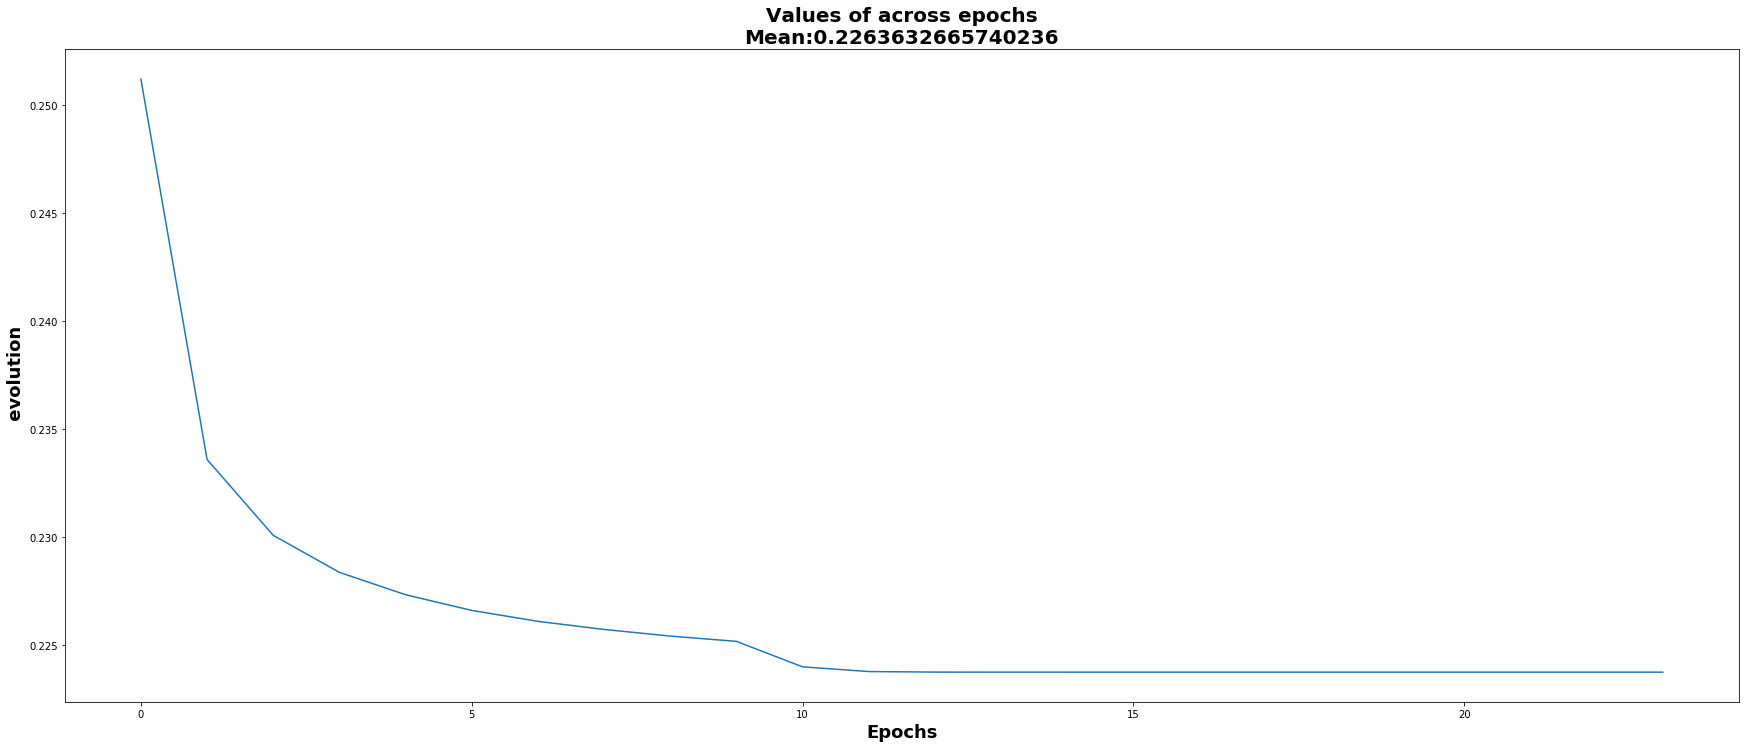

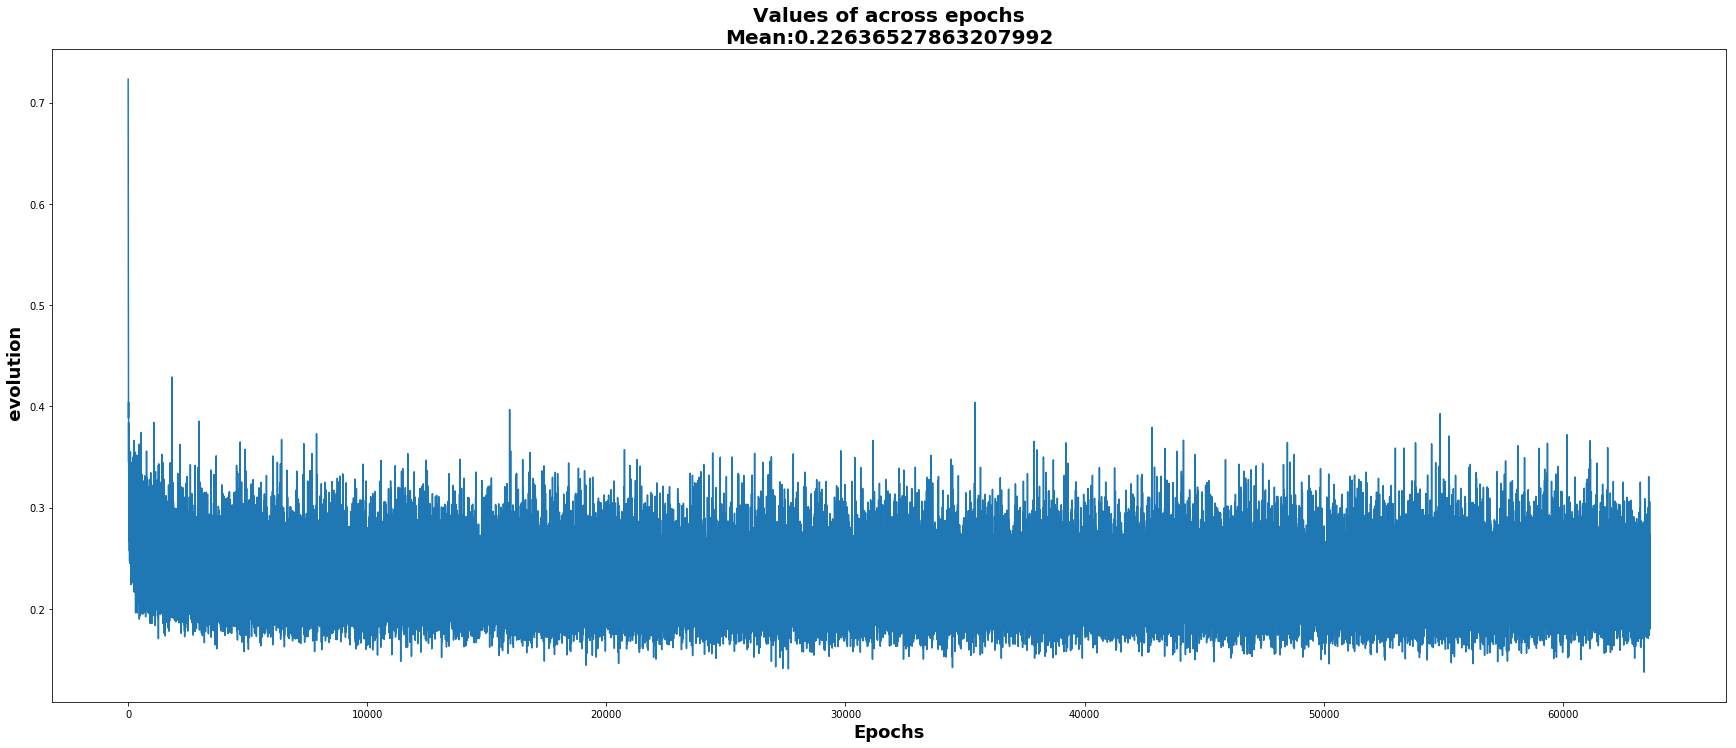

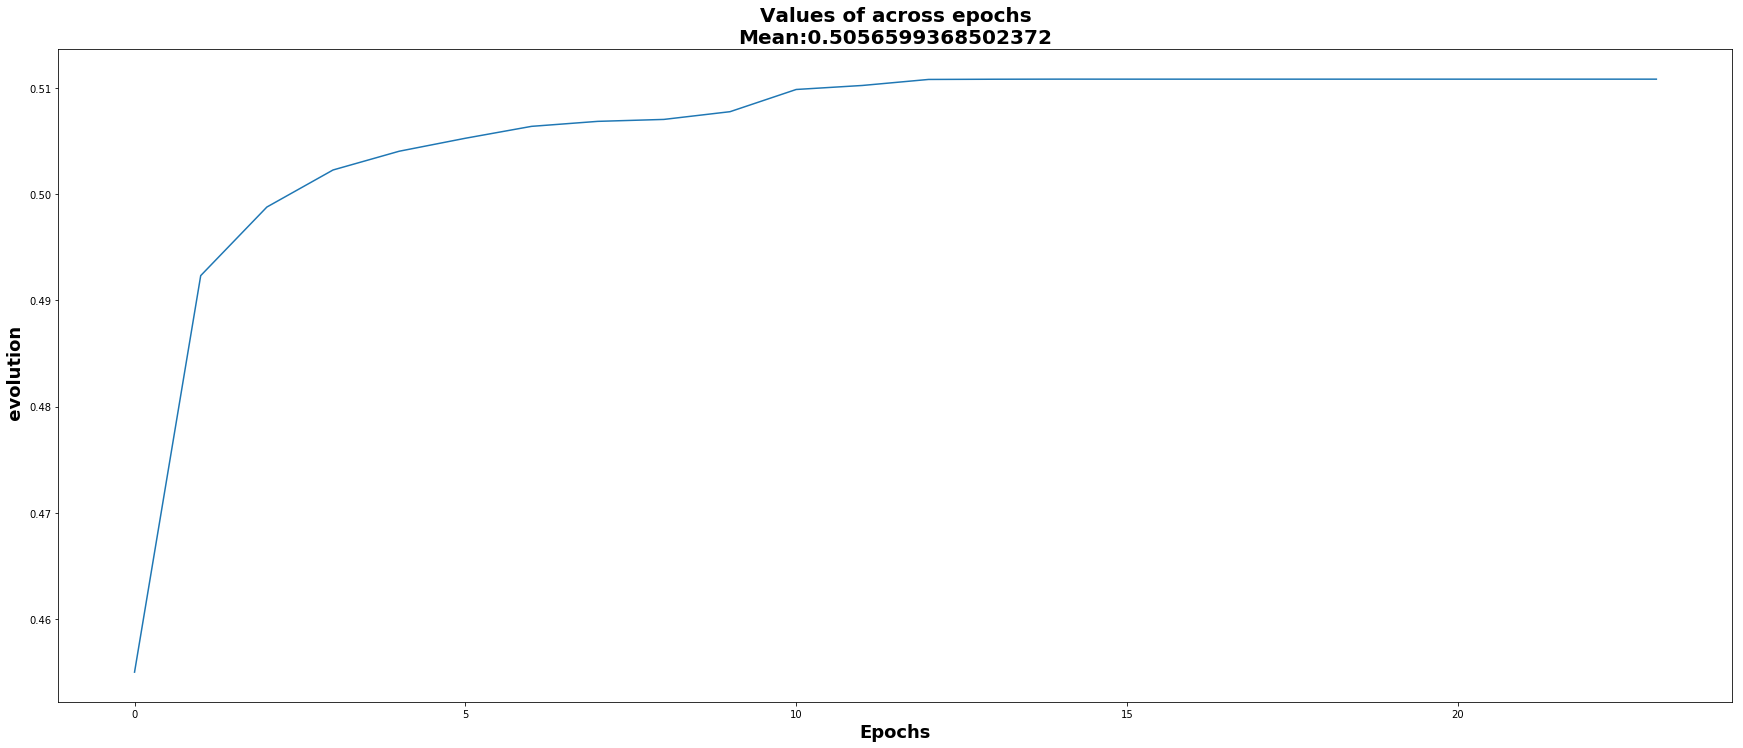

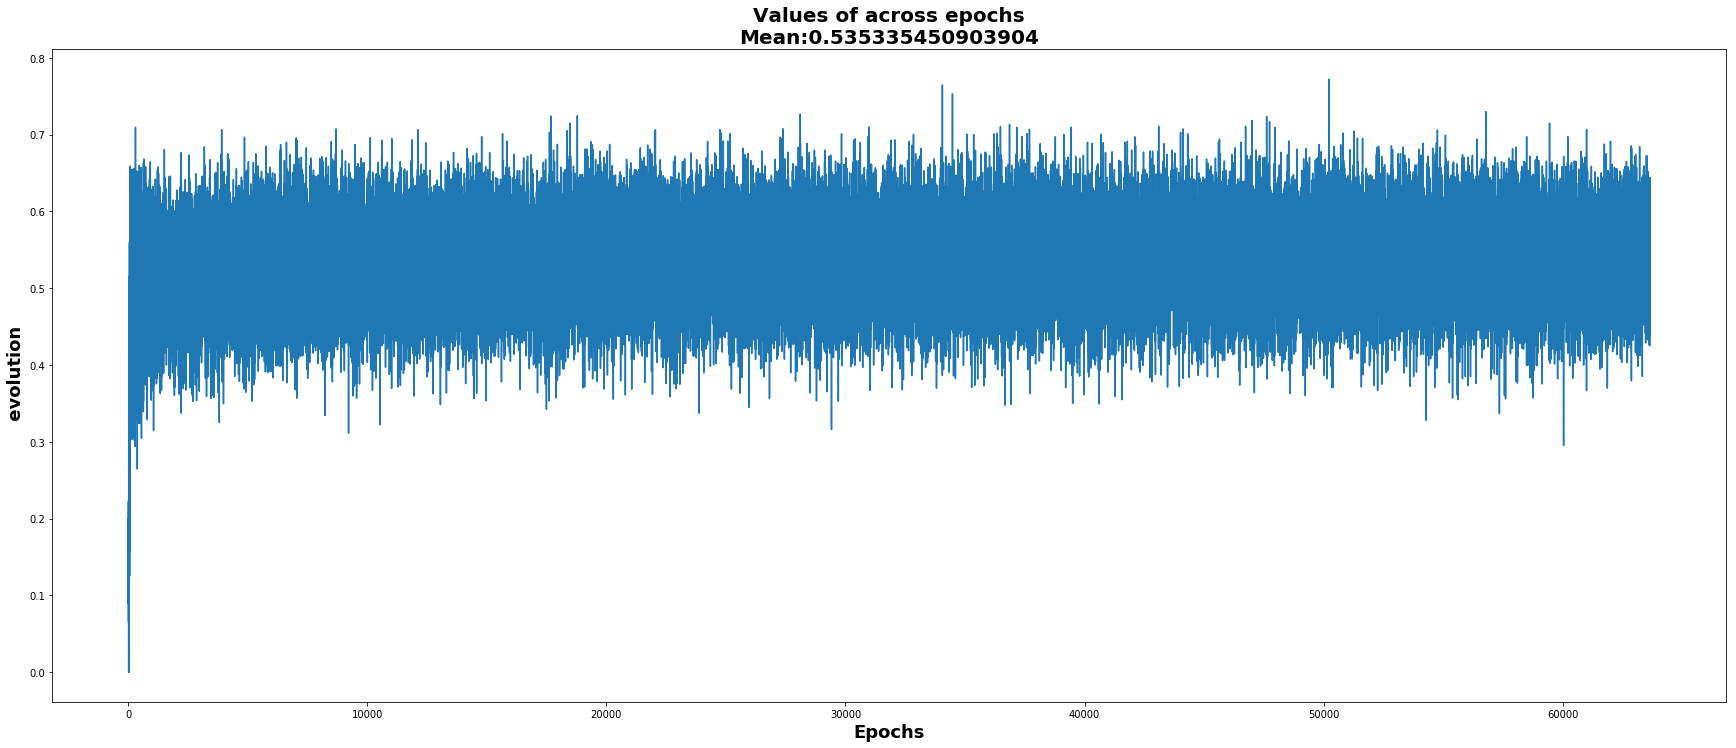

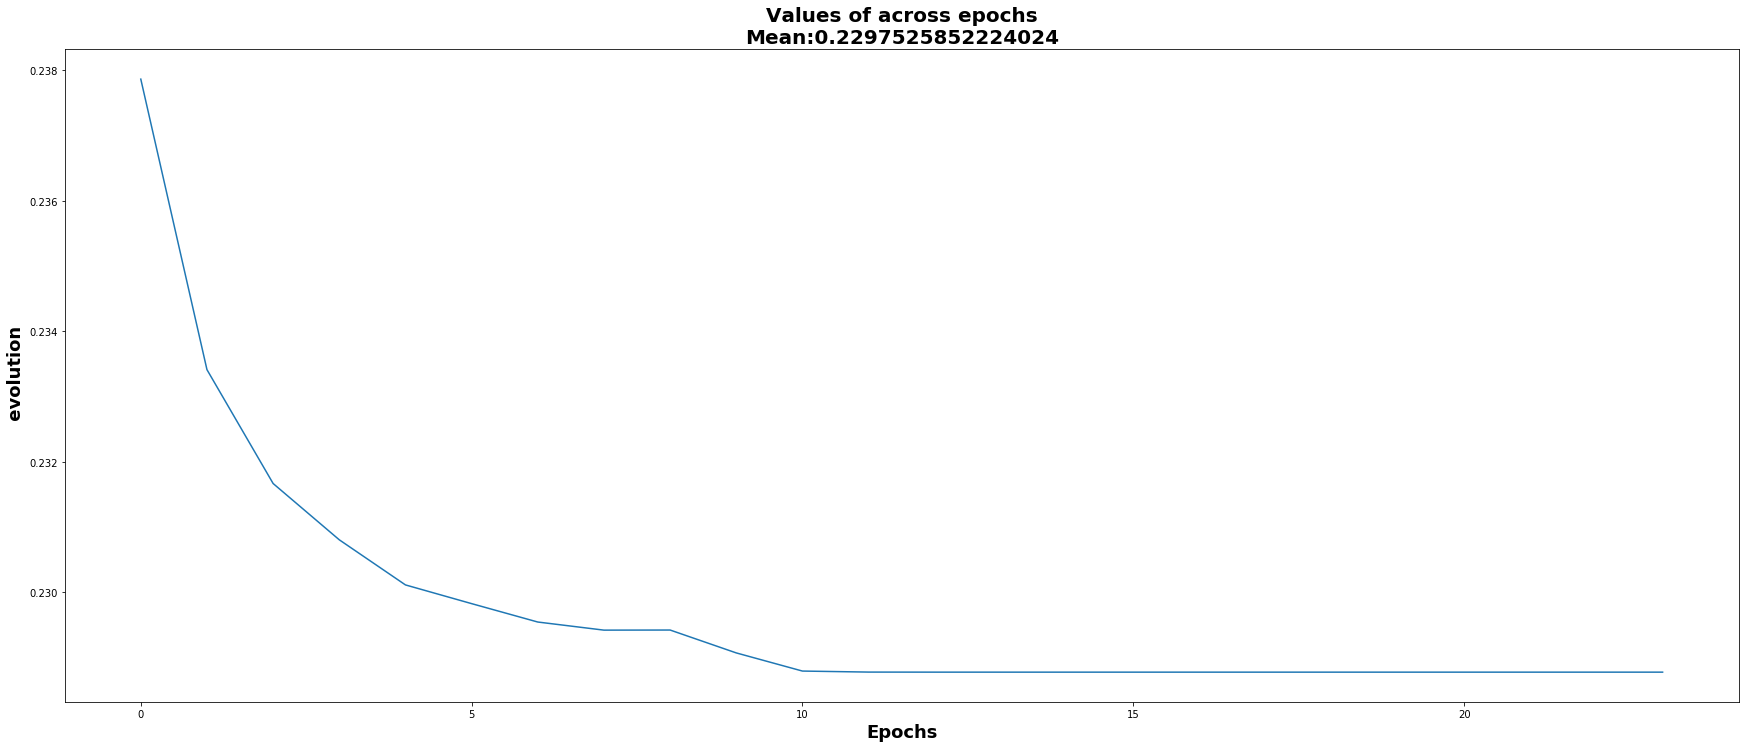

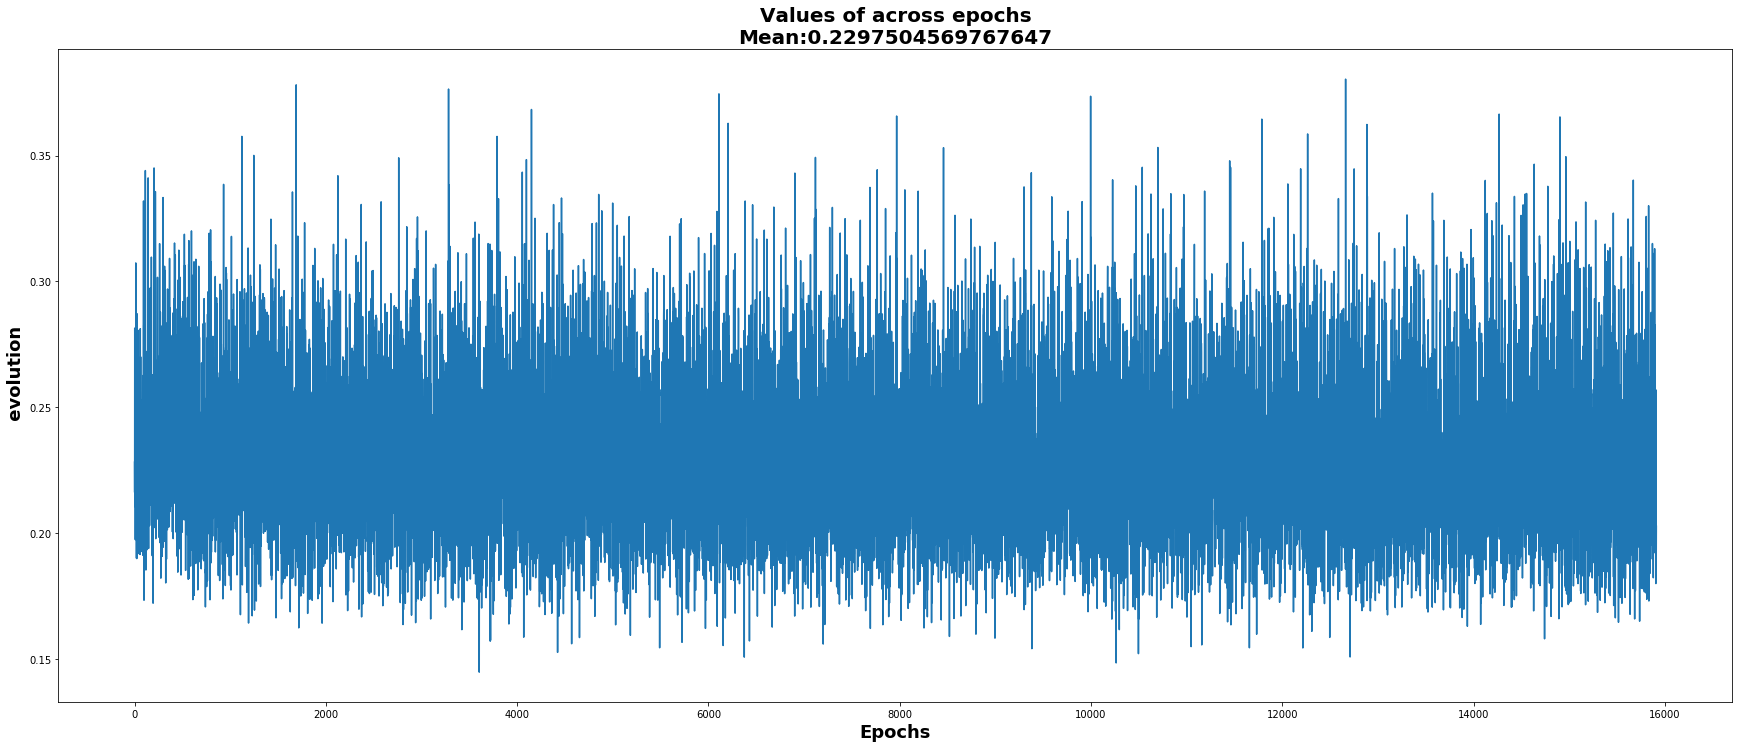

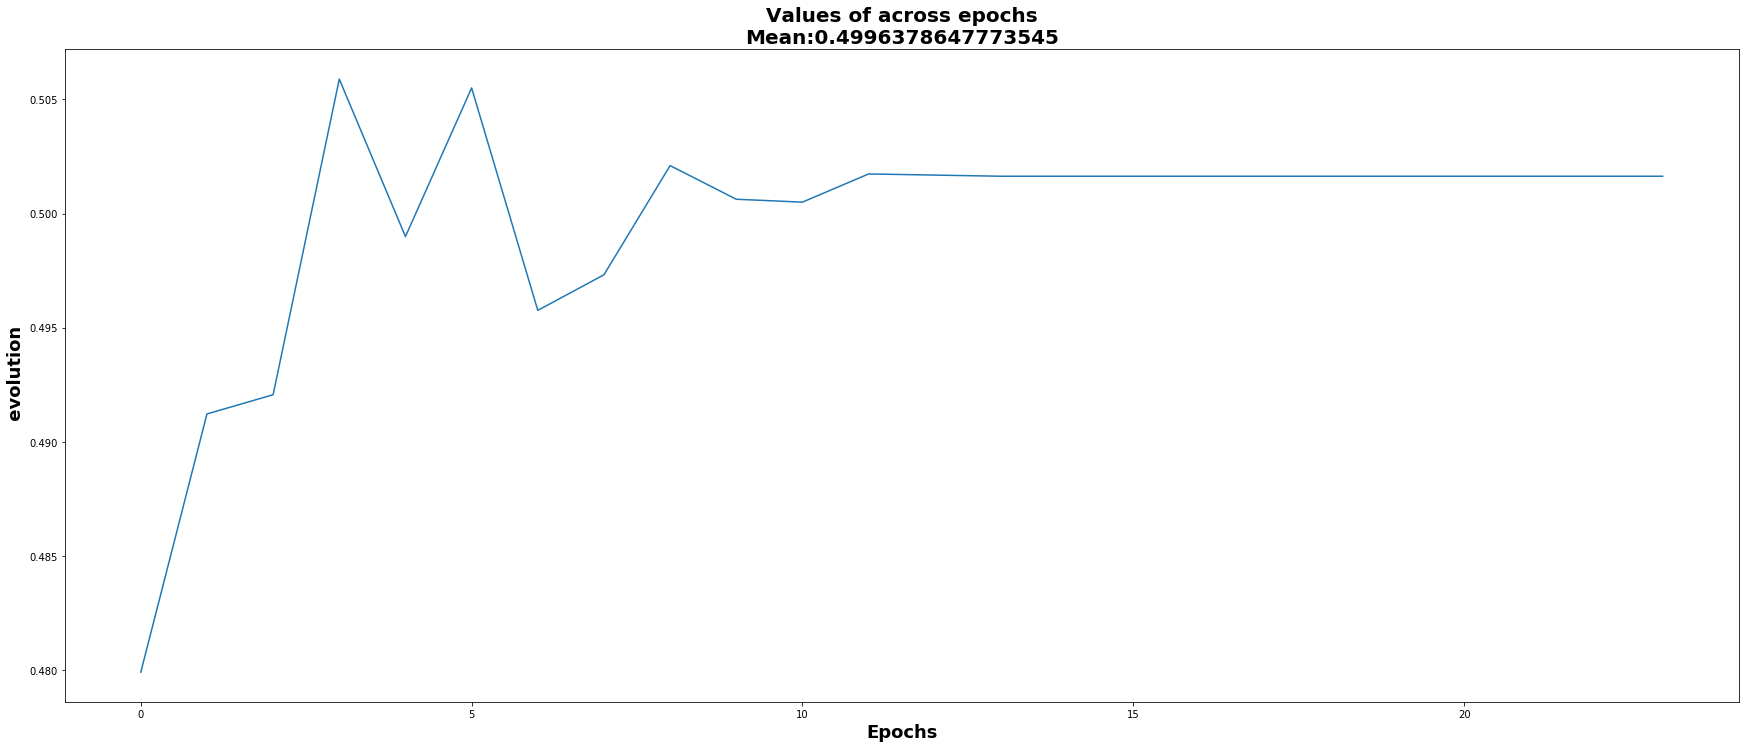

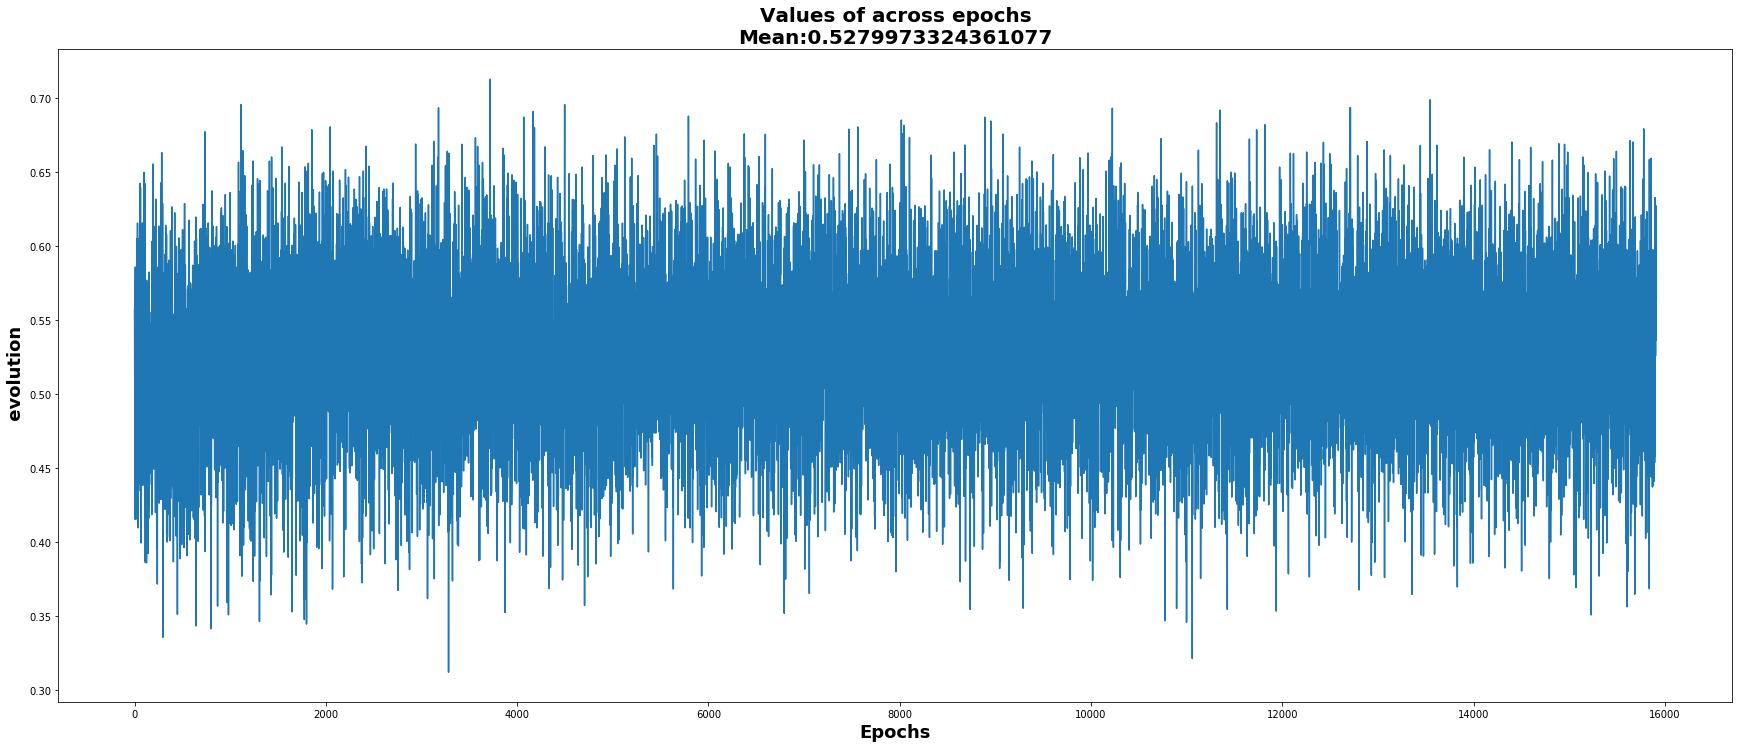

In [5]:
vitExperiment.losses_train_epoch.plot()
vitExperiment.losses_train_batch.plot()
vitExperiment.f1_train_epoch.plot()
vitExperiment.f1_train_batch.plot()
vitExperiment.losses_val_epoch.plot()
vitExperiment.losses_val_batch.plot()
vitExperiment.f1_val_epoch.plot()
vitExperiment.f1_val_batch.plot()


In [ ]:
self = vitExperiment

input, target = next(iter(self.valLoader))

input_var = torch.autograd.Variable(input, volatile=True)
target_var = torch.autograd.Variable(target, volatile=True)

# compute output
output = self.model(input_var)

if True:#i==0:
    predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
    targetMemory = target.cpu().detach().numpy()
else:
    predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
    targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)


#print('Validation: [{0}/{1}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(i, len(self.valLoader), batch_time=batch_time,loss=losses, f1=f1))


f1_score(predictionMemory, targetMemory, average='weighted')

# Evaluation of the models

In [14]:
vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments','vit','*'))

for path in vit_exp_list:
    path_json = os.path.join(path, 'experiment_log.json')
    print('\nLOOKING AT EXPERIMENT : {}'.format(os.path.basename(path)))

  
    with open(path_json, 'r') as json_file:

        data = json.load(json_file)
            
        try:
            n_epoch = len(data['losses_train_epoch'])

            plt.figure(figsize=(30,12))
            plt.plot(data['losses_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_val_epoch'], s=50, color = 'r', label = 'Validation loss (epoch)')
            plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], s=50, color = 'g', label = 'Training loss (epoch)')
            plt.plot(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], color = 'g')
            plt.title('Evolution of the losses during training - Experiment : {}\nMODEL: {} | Optimizer:{} | N_epoch: {} | lr:{} \nbatch_size:{} | weight_decay:{} | vit_attr:{} '.format(os.path.basename(path),
                                                                                                                                                                     data['model_type'],
                                                                                                                                                                     data['optimizer'] if 'optimizer' in list(data.keys()) else 'SGD' ,  
                                                                                                                                                                     n_epoch,
                                                                                                                                                                     data['lr'],
                                                                                                                                                                     data['batch_size'],
                                                                                                                                                                     data['weight_decay'],
                                                                                                                                                                     data['vit_attr']), fontsize=20, weight='bold')
            plt.xlabel('Epochs', fontsize=18, weight='bold')
            plt.ylabel('Loss evolution', fontsize=18, weight='bold')
            plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
            _ = plt.legend()
            plt.show()

            print('Number of epoch: {}'.format(n_epoch))
        except KeyError:
          print(path)
          
vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments','vit','*'))

for path in vit_exp_list:
    path_json = os.path.join(path, 'experiment_log.json')
    print('\nLOOKING AT EXPERIMENT : {}'.format(os.path.basename(path)))

  
    with open(path_json, 'r') as json_file:

        data = json.load(json_file)
            
        try:
            n_epoch = len(data['losses_train_epoch'])

            plt.figure(figsize=(30,12))
            plt.plot(data['f1_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_val_epoch'], s=50, color = 'r', label = 'Validation F1-Score (epoch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], s=50, color = 'g', label = 'Training F1-Score (epoch)')
            plt.plot(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], color = 'g')
            plt.title('Evolution of the F1 Score during training - Experiment : {}\nMODEL: {} | Optimizer:{} | N_epoch: {} | lr:{} \nbatch_size:{} | weight_decay:{} | vit_attr:{} '.format(os.path.basename(path),
                                                                                                                                                                     data['model_type'],
                                                                                                                                                                     data['optimizer'] if 'optimizer' in list(data.keys()) else 'SGD' ,  
                                                                                                                                                                     n_epoch,
                                                                                                                                                                     data['lr'],
                                                                                                                                                                     data['batch_size'],
                                                                                                                                                                     data['weight_decay'],
                                                                                                                                                                     data['vit_attr']), fontsize=20, weight='bold')
            plt.xlabel('Epochs', fontsize=18, weight='bold')
            plt.ylabel('F1 evolution', fontsize=18, weight='bold')
            plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
            _ = plt.legend()
            plt.ylim((0,1))
            plt.show()



            print('Number of epoch: {}'.format(n_epoch))
        except KeyError:
          print(path)
          


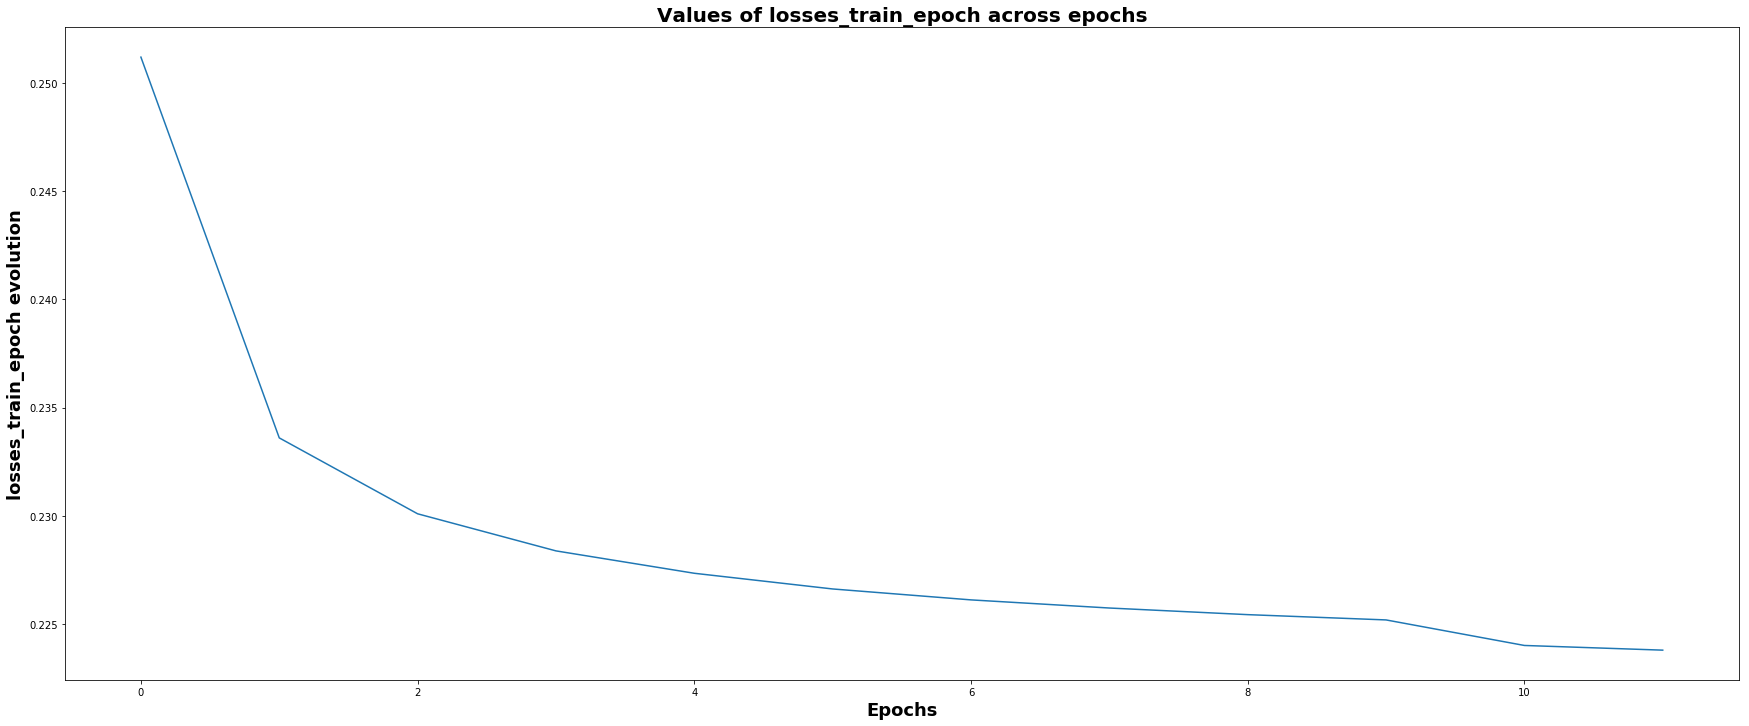

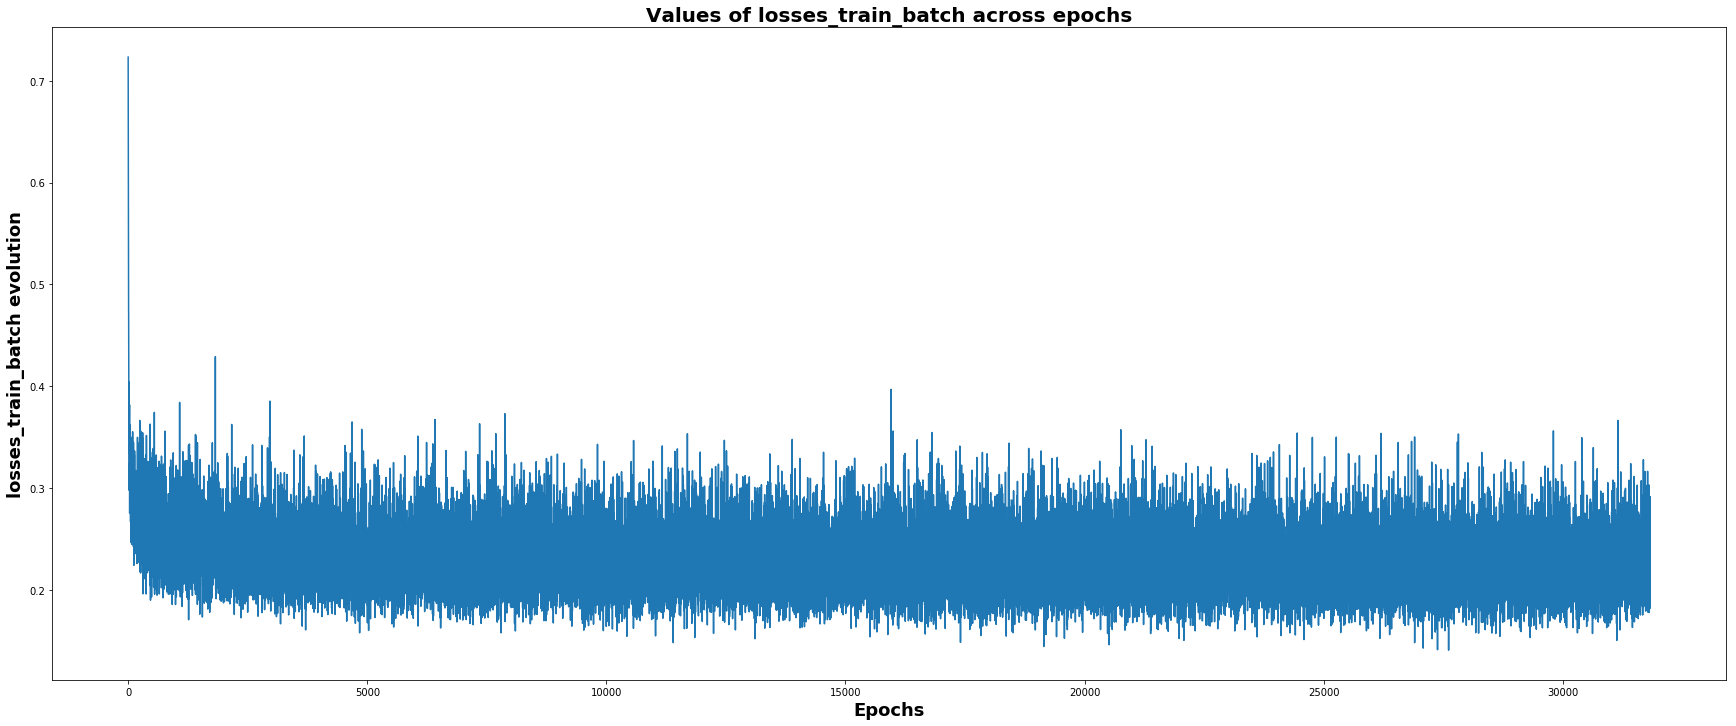

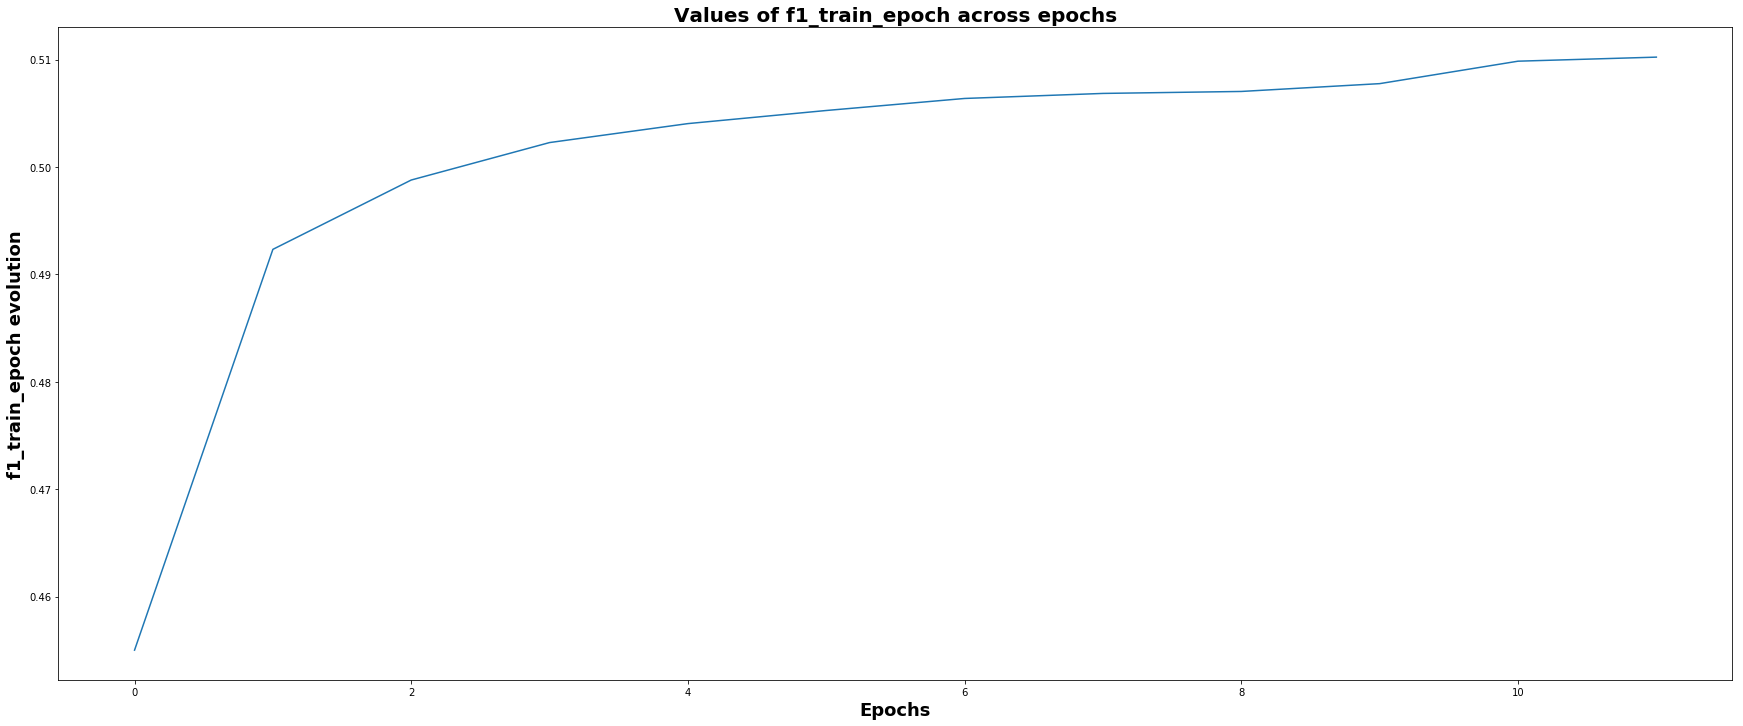

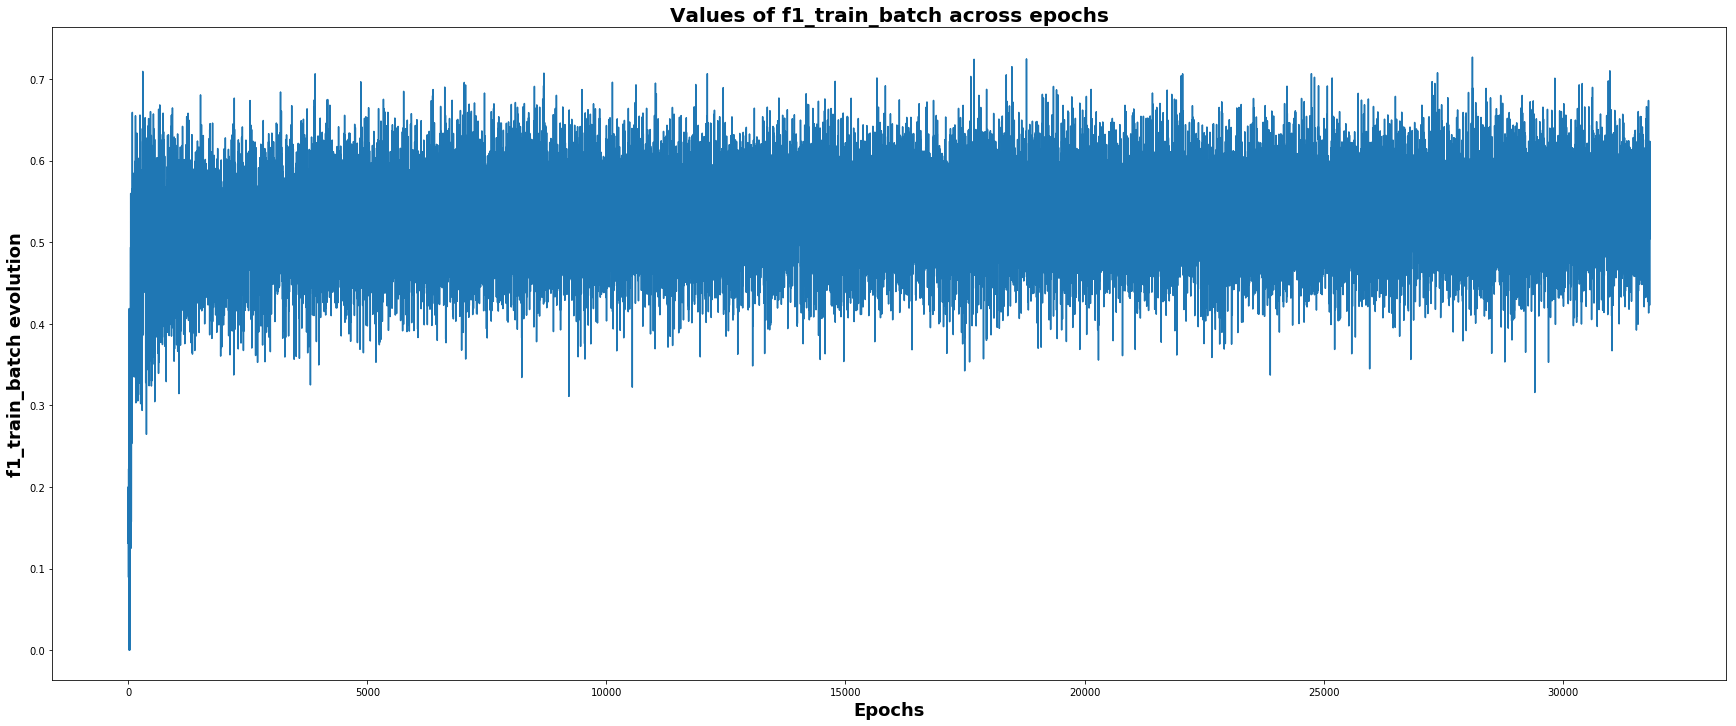

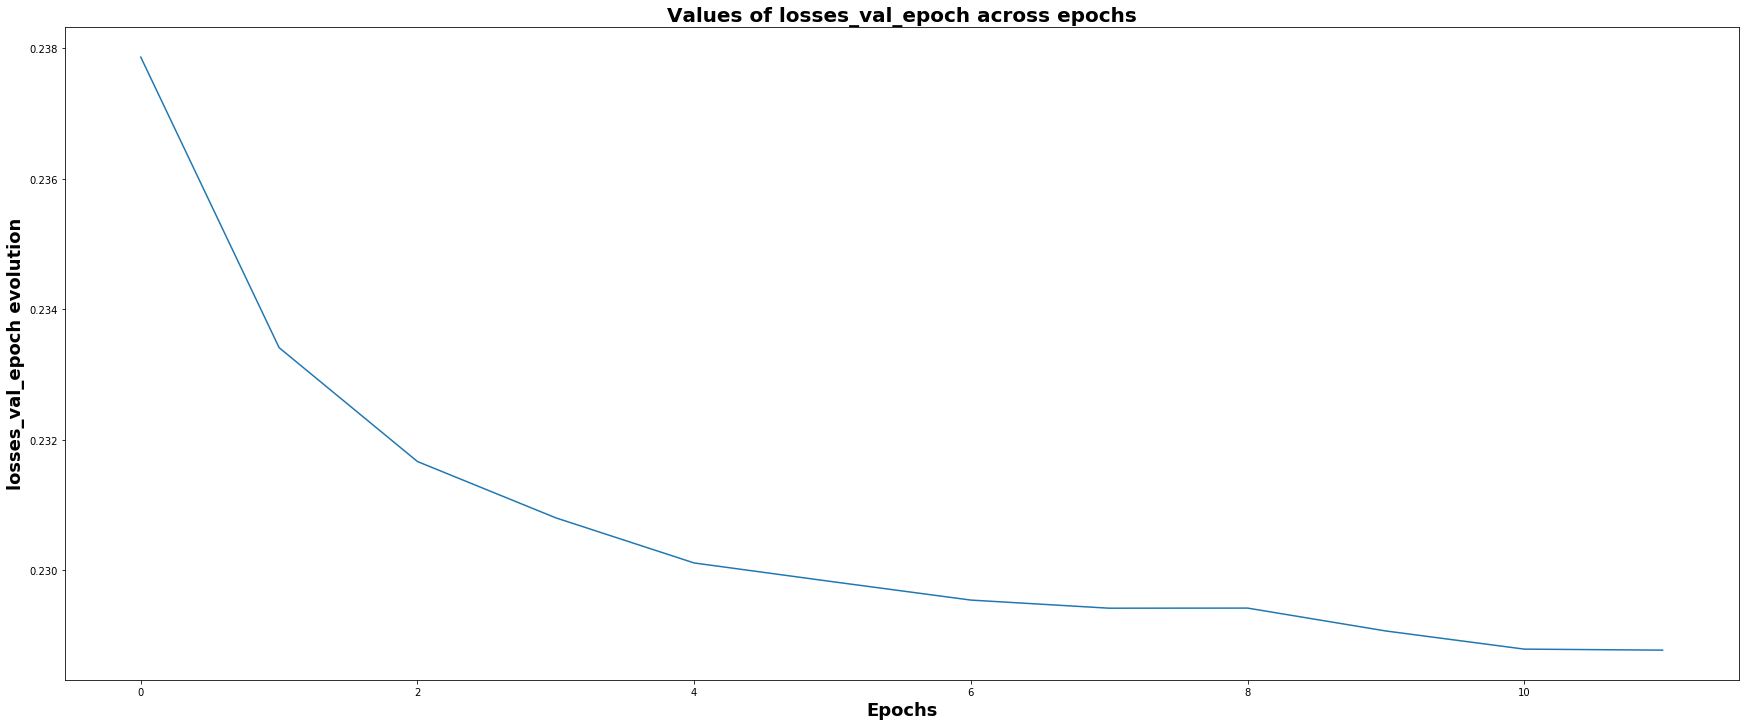

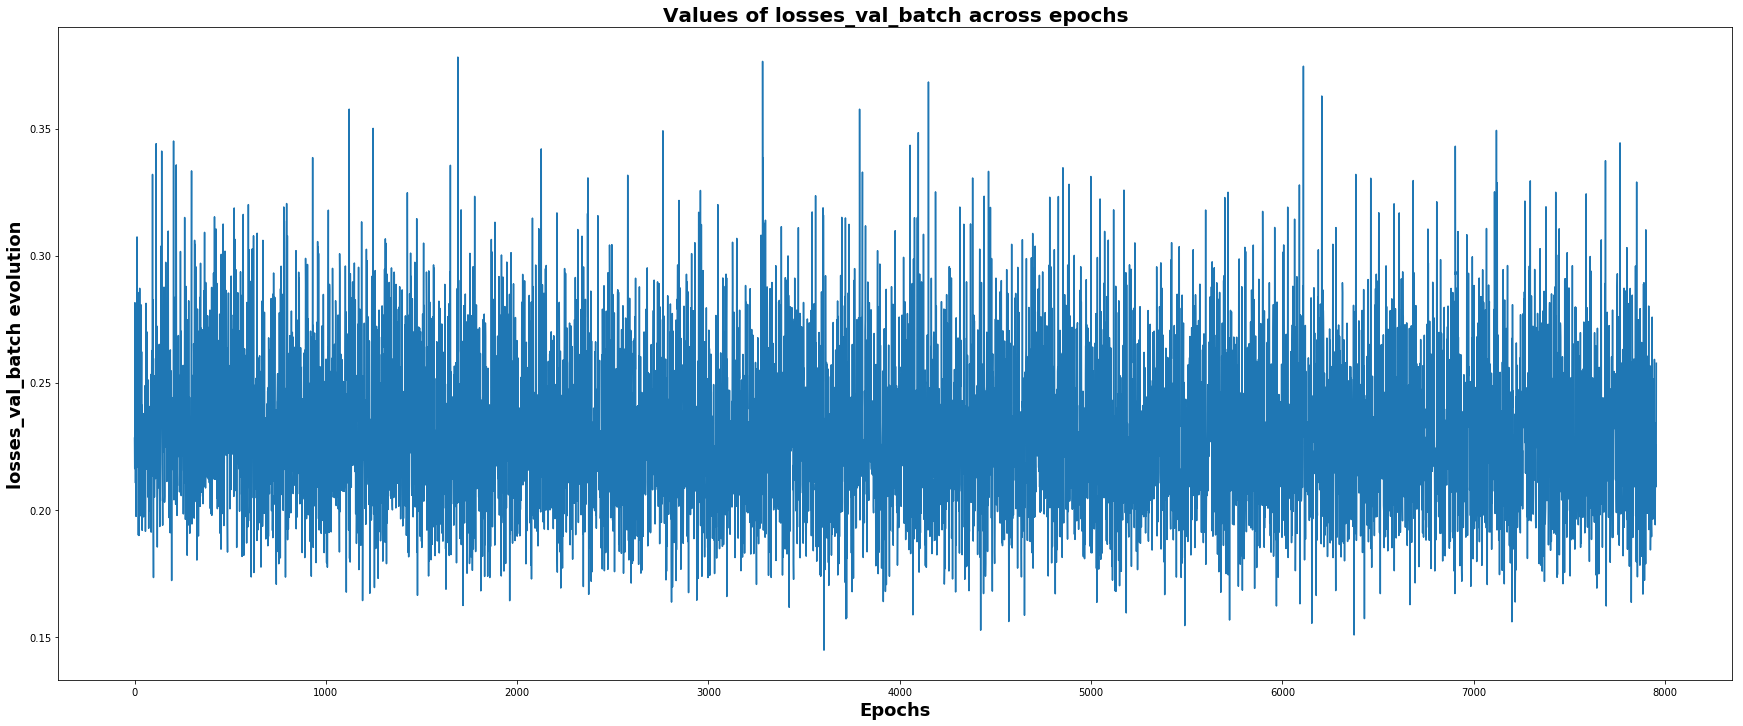

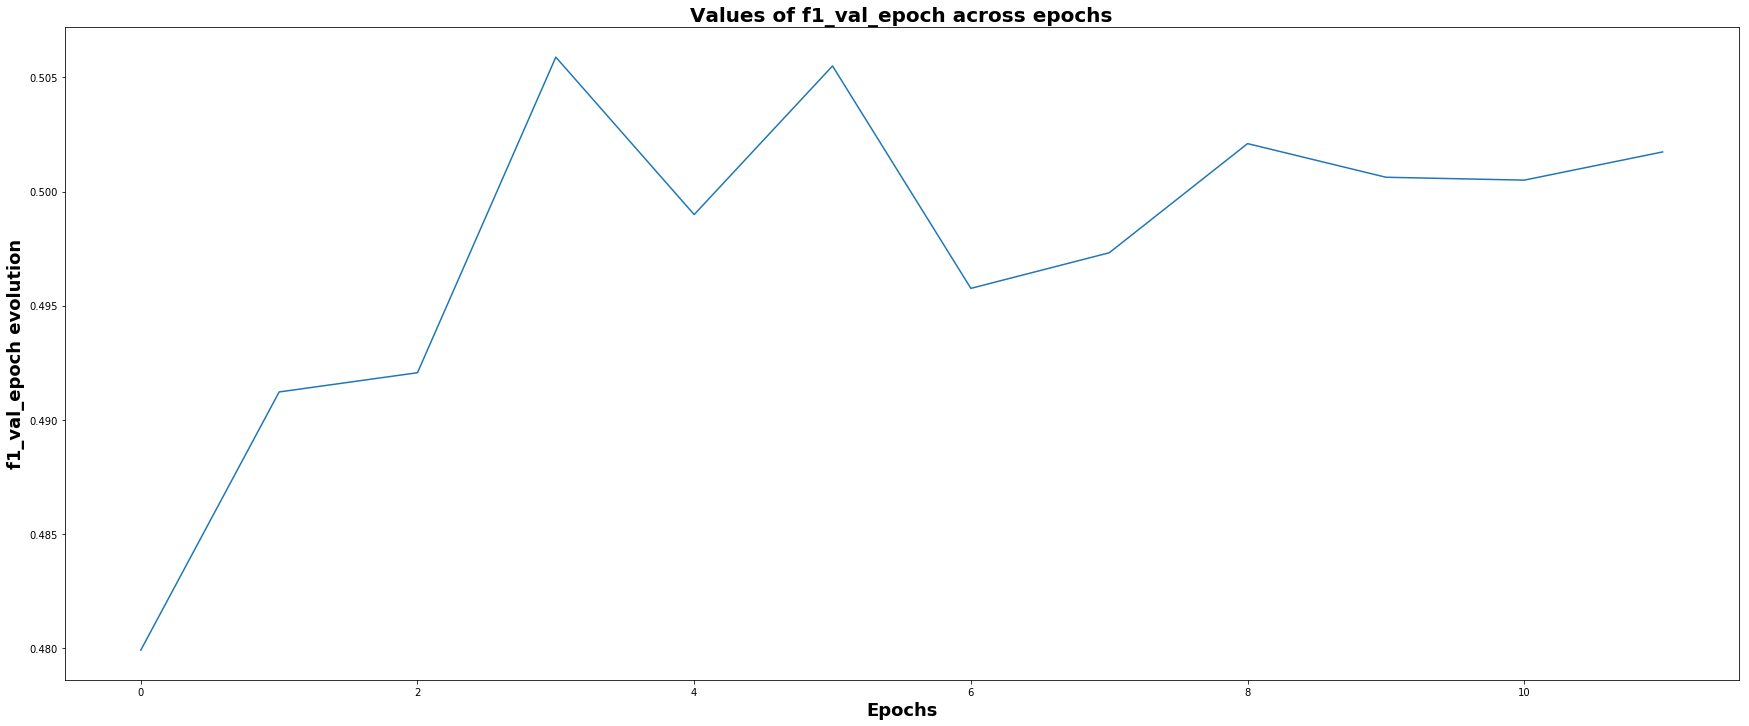

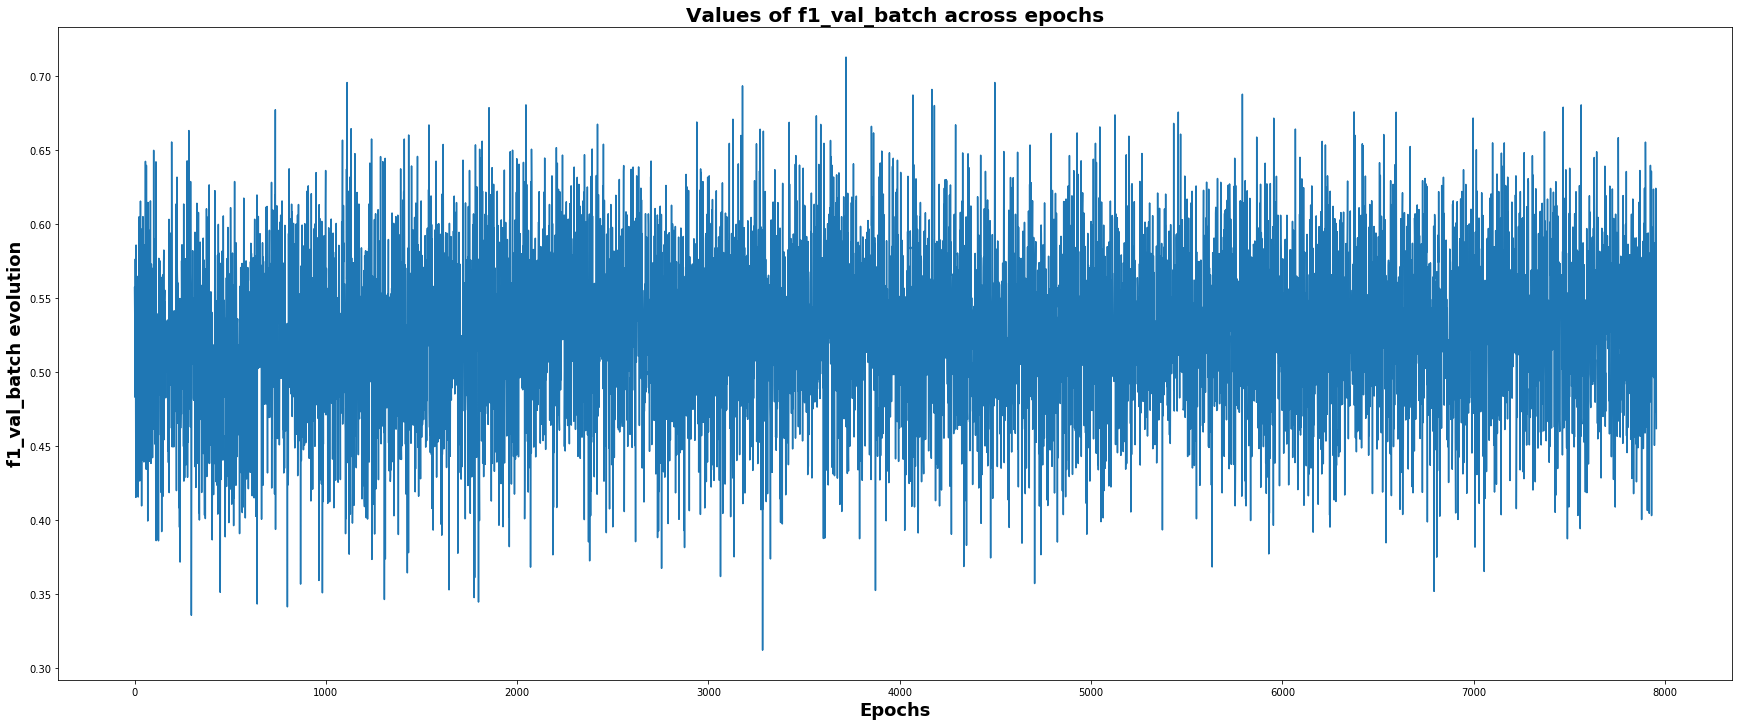

In [20]:
def plot_loss(loss, name):
    
    plt.figure(figsize=(30,12))
    plt.plot(loss)
    plt.title('Values of {} across epochs'.format(name), fontsize=20, weight='bold')
    plt.xlabel('Epochs', fontsize=18, weight='bold')
    plt.ylabel(name+' evolution', fontsize=18, weight='bold')
    
plot_loss(data['losses_train_epoch'], 'losses_train_epoch')
plot_loss(data['losses_train_batch'], 'losses_train_batch')
plot_loss(data['f1_train_epoch'], 'f1_train_epoch')
plot_loss(data['f1_train_batch'], 'f1_train_batch')
plot_loss(data['losses_val_epoch'], 'losses_val_epoch')
plot_loss(data['losses_val_batch'], 'losses_val_batch')
plot_loss(data['f1_val_epoch'], 'f1_val_epoch')
plot_loss(data['f1_val_batch'], 'f1_val_batch')

In [ ]:
vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments','vit','*'))
plt.figure(figsize=(30,12))
for path in vit_exp_list:
    path_json = os.path.join(path, 'experiment_log.json')
    with open(path_json, 'r') as json_file:

        data = json.load(json_file)
            
        try:
            n_epoch = len(data['losses_train_epoch'])

            #plt.plot(data['f1_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_val_epoch'], s=50, label = 'Validation F1-Score (epoch) - {}'.format(os.path.basename(path)))
            #plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], s=50, color = 'g', label = 'Training F1-Score (epoch) - {}'.format(os.path.basename(path)))
            #plt.plot(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'])

        except KeyError:
          print(path)
plt.xlabel('Epochs', fontsize=18, weight='bold')
plt.ylabel('F1 evolution', fontsize=18, weight='bold')
plt.xticks(ticks = np.arange(25), labels=[str(i) for i in np.arange(1,25+1)])
_ = plt.legend()
plt.ylim((0,1))
plt.show()

In [ ]:
from tools import displayPredictions

# Model creation
#model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
#model.eval()
#model.classifier = nn.Linear(1024, 19) 
#displayPredictions(model, n=4)



# Data Preparation
train_df_X, train_df_Y, test_df_X, test_df_Y = splitTrainTest(XTrain, YTrain, fraction=0.8)
trainImageDataset = ImageDataset(train_df_X, train_df_Y, root_data)
testImageDataset = ImageDataset(test_df_X, test_df_Y, root_data)

trainLoader = torch.utils.data.DataLoader(trainImageDataset,batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testImageDataset,batch_size=64, shuffle=True)


# Model creation
modelTrained = retrieveModel(trained=True)
modelNaive = retrieveModel(trained=False)

#load images
image, label = next(iter(testLoader))
label = label.numpy().astype(int)


#Prediction
predTrained = modelTrained(image.cuda())
predNaive = modelNaive(image.cuda())
predTrained = (torch.sigmoid(predTrained).cpu().detach().numpy()>.5).astype(int)
predNaive =nbr_labels_positive = torch.tensor([25673,71831,34014,33338,2383,8303,21697,28814,8353,12597,25017,10378,24582,10355,23583,12911,3325,51751,14534]) #number of labels
nbr_labels_negative = nbr_labels_positive.sum()*torch.ones(19)-nbr_labels_positive
coeffs = nbr_labels_negative/nbr_labels_positive    #coefficients for each label
coeffs = coeffs.to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=coeffs) (torch.sigmoid(predNaive).cpu().detach().numpy()>.5).astype(int)

# Compute scores
f1Trained = f1_score(predTrained, label, average='weighted')
f1Naive = f1_score(predNaive, label, average='weighted')
print('F1 score for the Naive model is: {}\nF1 score for the Trained model is: {}')